# Persistence algorithm 을 이용한 forecasting 

- Persistence Algorithm : last value 를 next value 로 예측에 사용


- 약간의 noise 를 추가한 seasonality 와 trend 가 있는 인공 합성 time series 이용 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

np.random.seed(101)

아래 코드는 다음과 같은 작업을 수행합니다:

trend 함수를 정의하여 주어진 시간(time)에 대한 선형 추세를 계산합니다. 기울기(slope) 인자를 통해 추세의 강도를 조절할 수 있습니다.  

seasonal_pattern 함수를 정의하여 시간(season_time)에 대한 계절성 패턴을 생성합니다. 이 예에서는 코사인 함수와 지수 함수를 사용하여 임의의 패턴을 만듭니다.  

seasonality 함수를 정의하여 시간(time)에 대해 주기적으로 반복되는 계절성 패턴을 생성합니다. 주기(period), 진폭(amplitude), 및 위상(phase) 인자를 사용하여 계절성 패턴의 특성을 조절할 수 있습니다.  

noise 함수를 정의하여 시간(time)에 대한 노이즈를 생성합니다. 노이즈 수준(noise_level)과 시드(seed) 인자를 사용하여 노이즈의 특성을 조절할 수 있습니다.  

C:\Users\chade\AppData\Local\Temp\ipykernel_23288\1950279596.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


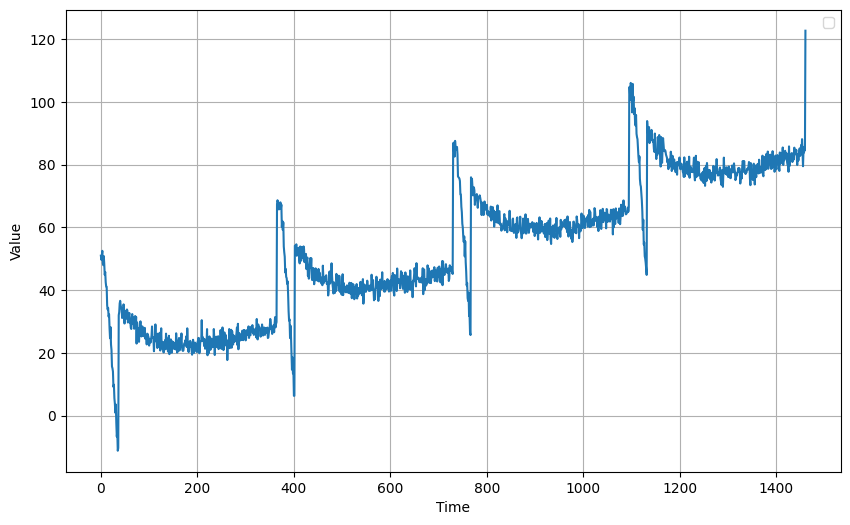

In [8]:
def trend(time,slope=0):
    return slope *time

def seasonal_pattern(season_time):
    """
    임의의 pattern 함수
    """
    return np.where(season_time<0.1,np.cos(season_time*7*np.pi),1/np.exp(5*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    """
    매 기간 마다 동일한 pattern 반복
    """
    season_time = ((time+phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4*365 +1, dtype="float32")

baseline= 10

series = trend(time,0.1)
amplitude = 40
slope = 0.01
noise_level=2

series = baseline + 0.05*time + seasonality(time,period=365,amplitude=amplitude)

series+= noise(time,noise_level,seed=42)

plt.figure(figsize=(10,6))
plt.plot(time,series)
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
series.shape

(1461,)

### 위에서 생성한 time series 를 train 와 validation set 으로 분할

시간(time) 및 시계열 데이터(series)를 split_time을 기준으로 훈련 세트와 테스트 세트로 나눕니다.  
그래프에서 훈련 세트는 파란색 선으로, 테스트 세트는 주황색 선으로 표시됩니다. 

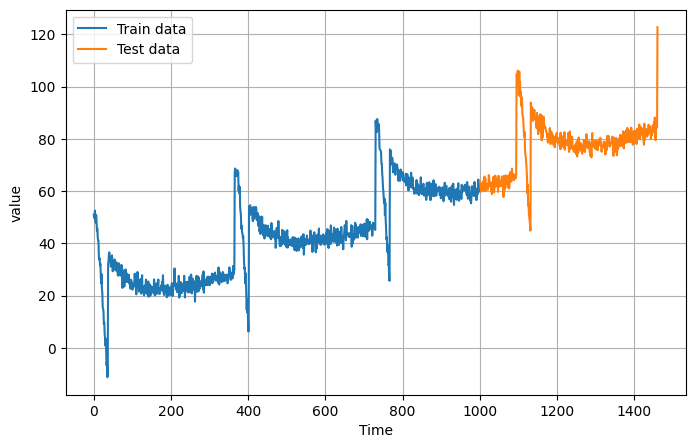

In [14]:
# points that can split series data with training and validation
split_time = 1000

# split data(train data)
time_train = time[:split_time]
X_train = series[:split_time]

# split data(test data)
time_test = time[split_time:]
X_test = series[split_time:]

plt.figure(figsize=(8,5))

# visualize train data

plt.plot(time_train,X_train,label="Train data")
plt.plot(time_test,X_test,label="Test data")

plt.xlabel("Time")
plt.ylabel("value")
plt.grid(True)
plt.legend()
plt.show()

## Naive Forecast

- last value 를 prediction 으로 사용 -> one-step behind prediction  

나이브 포캐스트(Naive Forecast) 방법은 매우 단순한 시계열 예측 방법입니다. 이 방법은 시계열 데이터의 현재 값을 바로 다음 시점의 예측값으로 사용합니다. 즉, 시간 
t에서의 값을 t+1에서의 값으로 예측하는 것입니다. 이렇게 하면, 예측은 항상 실제 값의 "한 스텝 뒤"에 위치하게 됩니다.   

예를 들어, split_time이 1000이라면, series[999]의 값이 첫 번째 예측값이 되어, 시간 1000에 대한 예측으로 사용됩니다. 이는 우리가 실제로 관측한 마지막 값(series[999])을 다음 시점(series[1000])의 예측값으로 사용하겠다는 것을 의미합니다.

`naive_forecast = series[split_time-1:-1]` 코드에서 split_time-1을 사용하는 것은 데이터를 분할하는 시점 바로 이전의 값에서 시작하여 예측을 생성하기 위함입니다. 이렇게 설정함으로써, 예측 시리즈(naive_forecast)는 실제 데이터 시리즈의 마지막 값 직전까지의 값을 포함하게 됩니다.

실제값이 naive_forecast 값과 유사한지 확인해 봅니다.

테스트 세트에 대한 원래 시계열 데이터와 naive forecasting을 그래프로 그립니다.

naive forecast 가 one-step behind 인지 그래프상으로 구별 어려우므로 validation period 의 앞부분으로 zoom in.

- naive forecast 가 1 step behind 지연되어 time series 를 그대로 재현하고 있음을 알 수 있습니다.

### naive forecast 와 validation period 값 간의 차이를  mse 와 mae 로 계산

테스트 세트와 naive forecasting 사이의 평균 제곱 오차(MSE)와 평균 절대 오차(MAE)를 계산합니다.

### 위의 값을 모든 prediction model 의 최소 성능의 baseline 으로 한다. 

# Real Data를 이용한 Naive Forecasting

parser 함수는 인자로 문자열 x를 받아서 datetime.strptime 함수를 사용하여 해당 문자열을 '%Y-%m' 형식의 datetime 객체로 변환합니다.  
```
"Month","Sales"
"1-01",266.0
"1-02",145.9
"1-03",183.1
"1-04",119.3
```

인터넷에서 샴푸 판매량 데이터셋(CSV 파일)을 읽어들이고, Pandas DataFrame 객체로 변환합니다. 
- parse_dates 매개변수를 사용하여 첫 번째 열(0)을 날짜로 처리하도록 설정합니다.
- date_parser 매개변수를 사용하여 앞서 정의한 parser 함수를 날짜 변환에 사용합니다.
- index_col 매개변수를 사용하여 날짜 열을 DataFrame의 인덱스로 설정합니다.
- header 매개변수를 사용하여 첫 번째 행을 열 이름으로 사용하도록 설정합니다.

### Train / Test set 분리

### Persistence Algorithm 정의

이 함수는 시계열 데이터에서 각 시점의 값을 다음 시점의 예측값으로 사용하는 모델입니다. 여기서 사용하는 주요 개념은 다음과 같습니다:

- **series**: 이는 시간에 따라 변하는 데이터를 담고 있는 Pandas의 Series나 DataFrame 객체입니다. 예를 들어, 매일의 온도나 매월의 판매량과 같은 시계열 데이터가 여기에 해당합니다.
- **split_time**: 이 값은 전체 시계열 데이터를 두 부분, 즉 학습 데이터와 테스트 데이터로 나누는 지점의 인덱스를 나타냅니다. 예를 들어, 전체 데이터가 100일치 있고 `split_time`이 70이라면, 처음 70일은 학습 데이터로, 나머지 30일은 테스트 데이터로 사용됩니다.

이 모델의 핵심 아이디어는 매우 단순합니다. 각 시점에서 바로 이전 시점의 실제 값을 현재 시점의 예측값으로 사용합니다. 함수는 테스트 데이터 기간 동안의 예측값을 제공하는데, 이는 각 시점에서 바로 앞 시점의 데이터 값을 의미합니다.

### 예측 및 평가